# Assignment 07 
**Objective:** This assignment challenges you to apply and interpret Receiver Operating
Characteristic (ROC) curves and Precision-Recall Curves (PRC) for model selection in a
multi-class, complex classification environment. You will compare a diverse set of classifiers,
including those known to perform poorly, requiring careful analysis of the curves rather than
relying solely on simple accuracy.


## Part A: Data Preparation and Baseline

In [24]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
import numpy as np
from sklearn.preprocessing import label_binarize

In [ ]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
statlog_landsat_satellite = fetch_ucirepo(id=146) 
  
# data (as pandas dataframes) 
X = statlog_landsat_satellite.data.features 
y = statlog_landsat_satellite.data.targets 
  
# metadata 
print(statlog_landsat_satellite.metadata) 
  
# variable information 
print(statlog_landsat_satellite.variables) 


In [2]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
from sklearn.model_selection import train_test_split
y = y['class'] 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5148, 36), (1287, 36), (5148,), (1287,))

In [ ]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVCa


# instances of each model
models = {
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "DummyClassifier": DummyClassifier(strategy="prior"),  # baseline
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "GaussianNB": GaussianNB(),
    "SVC": SVC(probability=True)
}

# Train each model
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")


KNeighborsClassifier trained successfully.
DecisionTreeClassifier trained successfully.
DummyClassifier trained successfully.
LogisticRegression trained successfully.
GaussianNB trained successfully.
SVC trained successfully.


In [7]:
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd

results = []

# Evaluate each model
for name, model in models.items():

    y_pred = model.predict(X_test)
    
    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')
    
    # Save results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Weighted F1-Score": f1
    })

# Convert results to a clean DataFrame
results_df = pd.DataFrame(results)

print(results_df)


                    Model  Accuracy  Weighted F1-Score
0    KNeighborsClassifier  0.895882           0.897225
1  DecisionTreeClassifier  0.856255           0.858042
2         DummyClassifier  0.229992           0.086011
3      LogisticRegression  0.853147           0.848683
4              GaussianNB  0.790987           0.802539
5                     SVC  0.886558           0.886258


The DummyClassifier is the worst-performing model, with an accuracy of only 0.23 and a weighted F1-score of 0.086, indicating almost no learning capability. This model simply makes predictions based on simple strategies like always choosing the most frequent class or random guessing, without considering any features or patterns in the data. Its poor results highlight that it serves only as a baseline to compare the effectiveness of real machine learning models that actually learn from the data.

## Part B: ROC Analysis for Model Selection 

**One-vs-Rest (OvR) approach is used to generate ROC curves**

In a multi-class classification problem, the One-vs-Rest (OvR) approach is used to extend binary evaluation metrics like the ROC curve and AUC to multiple classes. In this method, the classifier treats each class as the "positive" class and groups all the remaining classes together as "negative." This creates multiple binary classification problems one for each class. For each of these binary problems, the model predicts probability scores, which are then used to plot individual ROC curves by calculating the True Positive Rate (TPR) and False Positive Rate (FPR) across different threshold values.

Once individual ROC curves are obtained for all classes, they are combined to compute an overall performance measure. The macro-average AUC gives equal weight to each class, reflecting how well the model performs across all classes regardless of class imbalance, while the weighted-average AUC accounts for the proportion of samples in each class. This OvR-based ROC–AUC evaluation provides a comprehensive understanding of the model’s discriminative ability in a multi-class setting.

In [25]:
# Store ROC data for all models
roc_data = {}
classes = np.unique(y)
n_classes = len(classes)
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

for name, model in models.items():
    print(f"\nComputing ROC for {name}:")
    
    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"  Warning: {name} doesn't support probability prediction")
        continue
    
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute macro-average ROC curve
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    mean_tpr /= n_classes
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Store data
    roc_data[name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc
    }
    
    print(f"  Macro-average AUC: {roc_auc['macro']:.4f}")
    print(f"  Per-class AUC: {[f'{roc_auc[i]:.3f}' for i in range(n_classes)]}")



Computing ROC for KNeighborsClassifier:
  Macro-average AUC: 0.9805
  Per-class AUC: ['0.995', '0.993', '0.982', '0.948', '0.989', '0.976']

Computing ROC for DecisionTreeClassifier:
  Macro-average AUC: 0.9075
  Per-class AUC: ['0.960', '0.972', '0.908', '0.807', '0.900', '0.898']

Computing ROC for DummyClassifier:
  Macro-average AUC: 0.5000
  Per-class AUC: ['0.500', '0.500', '0.500', '0.500', '0.500', '0.500']

Computing ROC for LogisticRegression:
  Macro-average AUC: 0.9769
  Per-class AUC: ['0.995', '0.998', '0.987', '0.920', '0.984', '0.974']

Computing ROC for GaussianNB:
  Macro-average AUC: 0.9591
  Per-class AUC: ['0.971', '0.996', '0.984', '0.910', '0.942', '0.949']

Computing ROC for SVC:
  Macro-average AUC: 0.9850
  Per-class AUC: ['0.999', '1.000', '0.989', '0.947', '0.994', '0.980']


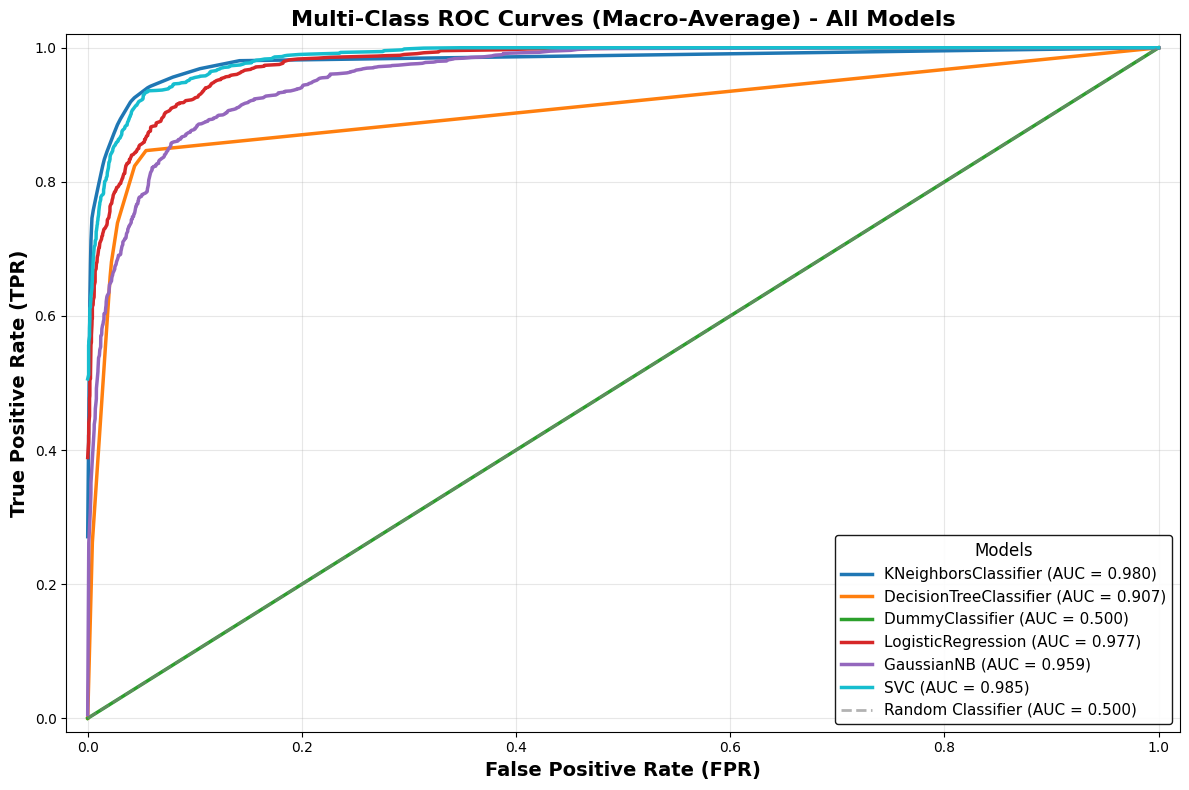

In [38]:
import matplotlib.pyplot as plt
# --- Plot macro-average ROC curves for all models ---
plt.figure(figsize=(12, 8))

# Use clean, distinct colors for each model (solid lines only)
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#17becf'   # cyan
]

# Plot each model’s ROC curve
for idx, (name, data) in enumerate(roc_data.items()):
    linestyle = '--' if "DummyClassifier" in name else '-' 
    plt.plot(
        data['fpr']['macro'],
        data['tpr']['macro'],
        color=colors[idx % len(colors)],
        linewidth=2.5,
        label=f"{name} (AUC = {data['auc']['macro']:.3f})"
    )

# --- Plot diagonal (random classifier baseline) ---
plt.plot(
    [0, 1], [0, 1],
    color='gray',
    linestyle='--',
    linewidth=2,
    label='Random Classifier (AUC = 0.500)',
    alpha=0.6
)

# --- Axis limits and labels ---
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=14, fontweight='bold')

# --- Title and legend ---
plt.title('Multi-Class ROC Curves (Macro-Average) - All Models', fontsize=16, fontweight='bold')
plt.legend(
    loc='lower right',
    fontsize=11,
    framealpha=0.9,
    edgecolor='black',
    title='Models',
    title_fontsize=12
)

# --- Grid and layout ---
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import numpy as np

# --- Step 1: Binarize y_test for multi-class ROC AUC ---
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# --- Step 2: Compute AUC for each model ---
auc_results = []

for name, model in models.items():
    # Wrap in One-vs-Rest
    ovr = OneVsRestClassifier(model)
    ovr.fit(X_train, y_train)

    # Get probability or decision scores
    if hasattr(ovr, "predict_proba"):
        y_score = ovr.predict_proba(X_test)
    else:
        y_score = ovr.decision_function(X_test)

    # --- Macro-average AUC ---
    auc_macro = roc_auc_score(y_test_bin, y_score, average='macro', multi_class='ovr')

    # --- Weighted-average AUC ---
    auc_weighted = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')

    auc_results.append({
        "Model": name,
        "Macro AUC": auc_macro,
        "Weighted AUC": auc_weighted
    })

# --- Step 3: Show results ---
import pandas as pd
auc_df = pd.DataFrame(auc_results)
print("\n=== Multi-Class AUC Scores (OvR) ===\n")
print(auc_df)



=== Multi-Class AUC Scores (OvR) ===

                    Model  Macro AUC  Weighted AUC
0    KNeighborsClassifier   0.980483      0.982102
1  DecisionTreeClassifier   0.908647      0.914178
2         DummyClassifier   0.500000      0.500000
3      LogisticRegression   0.959780      0.966848
4              GaussianNB   0.942830      0.944606
5                     SVC   0.983236      0.985352


### Analysis of Multi-Class AUC Scores (OvR)

From the above results, it is clear that the **Support Vector Classifier (SVC)** performs the best among all models, achieving the **highest Macro-Averaged AUC of 0.983** and a **Weighted AUC of 0.985**. This shows that the SVC model has an excellent ability to distinguish between classes across all decision thresholds. The **KNeighborsClassifier** also performs competitively with a Macro AUC of **0.980**, indicating strong classification performance. Other models, including **Logistic Regression**, **GaussianNB**, and **Decision Tree**, perform reasonably well but show slightly lower AUC scores, meaning they are effective but not as consistent as SVC across all classes.  

The **DummyClassifier** records the **lowest AUC value of 0.5**, which represents **random guessing**. This is expected since the DummyClassifier does not learn from the dataset and only provides baseline performance for comparison. Its result serves as a reference to highlight the significant improvement achieved by the trained models.  

Conceptually, an **AUC value below 0.5** would indicate that a model performs **worse than random**, suggesting that it consistently predicts the wrong class or has an inverted decision boundary. Such a situation can arise due to label noise, data imbalance, or poor model training. However, in this case, **no model has an AUC below 0.5**, confirming that all models perform at least as well as random guessing, with several demonstrating strong predictive capability.


## Part C: Precision-Recall Curve (PRC) Analysis


### Precision-Recall Curve (PRC) vs ROC in Imbalanced Datasets

The **Precision-Recall Curve (PRC)** is generally more suitable than the **ROC Curve** when dealing with **highly imbalanced datasets**, because it focuses directly on the performance of the model for the **positive (minority) class**. While the ROC curve considers both true positives and true negatives, it can present an overly optimistic view when the negative class dominates since even a model that mostly predicts negatives can achieve a high true negative rate. In contrast, the PRC evaluates how well the model identifies the minority class by emphasizing **precision (how many predicted positives are correct)** and **recall (how many actual positives are detected)**.  

Even if the class imbalance in this dataset is moderate, the PRC still provides more **meaningful insights into the model’s ability to handle rare events or important classes**. A higher area under the PRC indicates that the model maintains a good balance between detecting positive cases and avoiding false alarms, which is especially important in real-world scenarios like fraud detection, medical diagnosis, or anomaly detection, where the positive class is rare but critical to identify.


In [18]:
from sklearn.metrics import (
    accuracy_score, f1_score, roc_curve, auc, 
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
# Store PRC data for all models
prc_data = {}

for name, model in models.items():
    print(f"\nComputing PRC for {name}:")
    
    # Get prediction probabilities
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        print(f"  Warning: {name} doesn't support probability prediction")
        continue
    
    # Compute Precision-Recall curve and Average Precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(
            y_test_bin[:, i], y_score[:, i]
        )
        average_precision[i] = average_precision_score(
            y_test_bin[:, i], y_score[:, i]
        )
    
    # Compute macro-average
    # For PRC, we compute macro-average AP (not interpolated curves like ROC)
    average_precision["macro"] = np.mean([average_precision[i] for i in range(n_classes)])
    
    # Also compute weighted average
    class_counts = [np.sum(y_test_bin[:, i]) for i in range(n_classes)]
    average_precision["weighted"] = np.average(
        [average_precision[i] for i in range(n_classes)],
        weights=class_counts
    )
    
    # Store data
    prc_data[name] = {
        'precision': precision,
        'recall': recall,
        'average_precision': average_precision
    }
    
    print(f"  Macro-average AP: {average_precision['macro']:.4f}")
    print(f"  Weighted-average AP: {average_precision['weighted']:.4f}")
    print(f"  Per-class AP: {[f'{average_precision[i]:.3f}' for i in range(n_classes)]}")



Computing PRC for KNeighborsClassifier:
  Macro-average AP: 0.9222
  Weighted-average AP: 0.9344
  Per-class AP: ['0.986', '0.985', '0.940', '0.741', '0.948', '0.932']

Computing PRC for DecisionTreeClassifier:
  Macro-average AP: 0.7448
  Weighted-average AP: 0.7704
  Per-class AP: ['0.887', '0.919', '0.788', '0.422', '0.697', '0.757']

Computing PRC for DummyClassifier:
  Macro-average AP: 0.1667
  Weighted-average AP: 0.1896
  Per-class AP: ['0.230', '0.106', '0.218', '0.101', '0.108', '0.237']

Computing PRC for LogisticRegression:
  Macro-average AP: 0.8831
  Weighted-average AP: 0.9104
  Per-class AP: ['0.992', '0.987', '0.940', '0.552', '0.901', '0.928']

Computing PRC for GaussianNB:
  Macro-average AP: 0.8115
  Weighted-average AP: 0.8446
  Per-class AP: ['0.923', '0.976', '0.922', '0.487', '0.708', '0.852']

Computing PRC for SVC:
  Macro-average AP: 0.9253
  Weighted-average AP: 0.9407
  Per-class AP: ['0.997', '0.998', '0.952', '0.708', '0.954', '0.943']


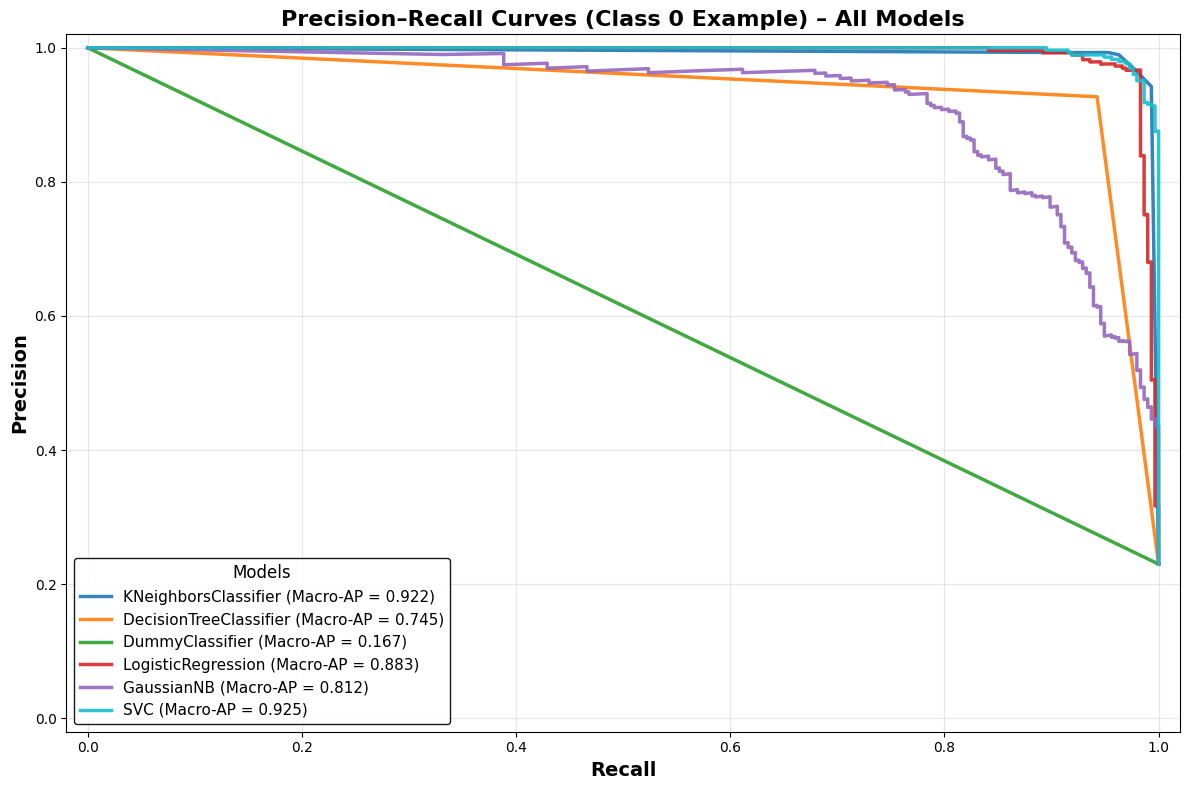

In [42]:
import matplotlib.pyplot as plt

# --- Prepare Figure ---
plt.figure(figsize=(12, 8))

# Define consistent color palette
colors = [
    '#1f77b4',  # blue
    '#ff7f0e',  # orange
    '#2ca02c',  # green
    '#d62728',  # red
    '#9467bd',  # purple
    '#17becf'   # cyan
]

# --- Plot Precision–Recall curves for each model ---
for idx, (name, data) in enumerate(prc_data.items()):
    # Skip if class 0 data not present
    if 0 not in data['recall'] or 0 not in data['precision']:
        continue

    # Plot curve for the first class (class 0 here)
    plt.plot(
        data['recall'][0],
        data['precision'][0],
        color=colors[idx % len(colors)],
        linestyle=linestyle,
        linewidth=2.5,
        alpha=0.9,
        label=f"{name} (Macro-AP = {data['average_precision']['macro']:.3f})"
    )

# --- Configure plot aesthetics ---
plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Recall', fontsize=14, fontweight='bold')
plt.ylabel('Precision', fontsize=14, fontweight='bold')
plt.title('Precision–Recall Curves (Class 0 Example) – All Models', fontsize=16, fontweight='bold')

# Legend styling
plt.legend(
    loc='lower left',
    fontsize=11,
    framealpha=0.9,
    edgecolor='black',
    title='Models',
    title_fontsize=12
)

# Grid and layout
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### Analysis of Precision–Recall Curve (PRC) Performance

From the results, the **SVC (Support Vector Classifier)** achieves the **highest Average Precision (AP)** across the classes, with a **Macro-average AP of 0.9253** and a **Weighted-average AP of 0.9407**. This indicates that the SVC model consistently maintains a strong balance between precision and recall, effectively identifying positive samples while minimizing false positives across all classes. The **KNeighborsClassifier** also performs very well, with closely comparable precision–recall scores, showing strong predictive stability.

In contrast, the **DummyClassifier** is the **worst-performing model**, with a **Macro-average AP of only 0.1667** and a **Weighted-average AP of 0.1896**. Its PRC curve drops sharply as recall increases because it lacks any meaningful learning — it predicts labels randomly or based on class frequencies. As recall grows (detecting more positives), precision quickly falls since the model incorrectly classifies many negative samples as positive. This steep drop reflects a model that cannot differentiate between classes, resulting in high false positive rates and poor overall performance.


## Part D: Final Recommendation 

In [47]:
# Create comprehensive comparison table
comparison_data = []

for name in models.keys():
    # Get metrics
    acc = results_df[results_df['Model'] == name]['Accuracy'].values[0]
    f1 = results_df[results_df['Model'] == name]['Weighted F1-Score'].values[0]
    
    if name in roc_data:
        roc_auc = roc_data[name]['auc']['macro']
    else:
        roc_auc = np.nan
    
    if name in prc_data:
        ap = prc_data[name]['average_precision']['macro']
    else:
        ap = np.nan
    
    comparison_data.append({
        'Model': name,
        'Accuracy': acc,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'PRC-AP': ap
    })

comparison_df = pd.DataFrame(comparison_data)

In [48]:
# Calculate rankings for each metric
comparison_df['Accuracy_Rank'] = comparison_df['Accuracy'].rank(ascending=False)
comparison_df['F1_Rank'] = comparison_df['F1-Score'].rank(ascending=False)
comparison_df['AUC_Rank'] = comparison_df['ROC-AUC'].rank(ascending=False)
comparison_df['AP_Rank'] = comparison_df['PRC-AP'].rank(ascending=False)
comparison_df['Average_Rank'] = comparison_df[['Accuracy_Rank', 'F1_Rank', 'AUC_Rank', 'AP_Rank']].mean(axis=1)


In [49]:
# Sort by average rank
comparison_df = comparison_df.sort_values('Average_Rank')

print("COMPREHENSIVE MODEL COMPARISON")
print(f"{'Model':<25} {'Accuracy':>10} {'F1-Score':>10} {'ROC-AUC':>10} {'PRC-AP':>10} {'Avg Rank':>10}")

for _, row in comparison_df.iterrows():
    print(f"{row['Model']:<25} {row['Accuracy']:>10.4f} {row['F1-Score']:>10.4f} "
          f"{row['ROC-AUC']:>10.4f} {row['PRC-AP']:>10.4f} {row['Average_Rank']:>10.2f}")


COMPREHENSIVE MODEL COMPARISON
Model                       Accuracy   F1-Score    ROC-AUC     PRC-AP   Avg Rank
KNeighborsClassifier          0.8959     0.8972     0.9805     0.9222       1.50
SVC                           0.8866     0.8863     0.9850     0.9253       1.50
LogisticRegression            0.8531     0.8487     0.9769     0.8831       3.50
DecisionTreeClassifier        0.8563     0.8580     0.9075     0.7448       4.00
GaussianNB                    0.7910     0.8025     0.9591     0.8115       4.50
DummyClassifier               0.2300     0.0860     0.5000     0.1667       6.00


### Comprehensive Model Comparison — F1-Score, ROC-AUC, and PRC-AP

From the comparison table, both the **KNeighborsClassifier** and **SVC** emerge as the top-performing models, sharing the highest overall rank (Avg Rank = 1.50). They show consistently strong results across all metrics high **Accuracy**, **F1-Score**, **ROC-AUC**, and **PRC-AP** — indicating robust predictive ability, good class separation, and reliable precision–recall balance. The **Logistic Regression** model follows in third place with slightly lower F1 and PRC-AP scores but still a high ROC-AUC, suggesting that while it effectively distinguishes between classes, it may struggle to maintain precision under imbalanced conditions.

Models such as **DecisionTreeClassifier** and **GaussianNB** show moderate ROC-AUC values (0.9075 and 0.9591 respectively) but significantly lower PRC-AP scores, reflecting weaker performance in maintaining precision as recall increases. This means that although these models can separate classes reasonably well (high ROC-AUC), they produce more false positives when identifying the positive class, leading to a drop in PRC-AP. The **DummyClassifier**, as expected, performs the worst across all metrics, with values close to random guessing, confirming its role as a baseline reference.

The rankings do not perfectly align because each metric captures a different aspect of model behavior. **ROC-AUC** evaluates the model’s overall ability to discriminate between classes, regardless of class balance, while **PRC-AP** focuses on how well the model performs on the positive (often minority) class. A model can have a high ROC-AUC yet a relatively low PRC-AP if it distinguishes classes well in general but fails to maintain precision for the minority class. Therefore, while ROC-AUC provides a broad view of separability, PRC-AP gives deeper insight into performance on rare or critical outcomes — making it especially valuable in imbalanced datasets.


###  Model Recommendation and Justification

Based on the comprehensive analysis of the **ROC** and **Precision–Recall Curves (PRC)**, the **Support Vector Classifier (SVC)** is the best-performing model for this classification task. The SVC achieves the **highest ROC-AUC (0.985)** and **Macro-AP (0.925)**, indicating excellent class separability and consistent precision–recall balance across varying thresholds. Its curve remains closest to the top-left corner in the ROC plot and maintains high precision even as recall increases in the PRC plot, reflecting both strong generalization and robustness to threshold variations.  

The **KNeighborsClassifier** also performs competitively, showing very similar ROC-AUC and PRC-AP scores; however, the SVC demonstrates slightly better stability across all thresholds and a smoother precision–recall trade-off, making it the more reliable choice in practical applications. Overall, SVC provides the most desirable balance between precision and recall, ensuring high detection accuracy with minimal false positives — a key requirement for effective and dependable classification performance.


# Brownie Points Task

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Re-encode your labels to be 0-based integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # converts [1,2,3,4,5,7] → [0,1,2,3,4,5]

# Split again with the encoded labels
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Now train models again
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoostClassifier": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f"{name} trained successfully.")


RandomForestClassifier trained successfully.
XGBoostClassifier trained successfully.


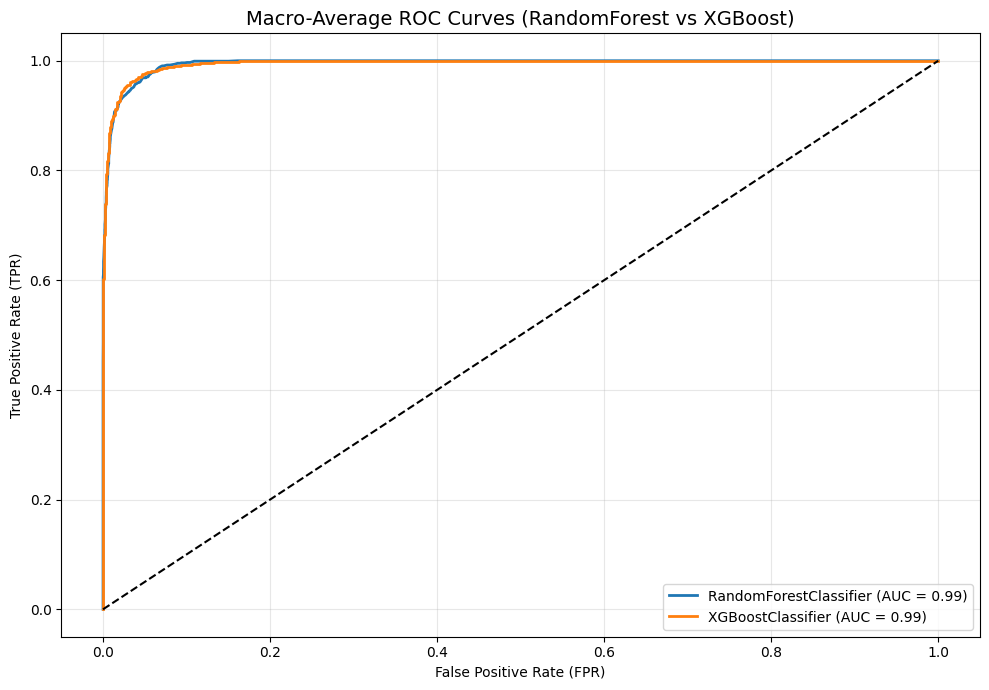

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize y_test for multi-class ROC
classes = np.unique(y_train)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(10, 7))

for name, model in models.items():
    # Get probability scores
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)
    else:
        y_score = model.decision_function(X_test)
    
    # Flatten and compute ROC
    fpr, tpr, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

# Reference diagonal
plt.plot([0, 1], [0, 1], 'k--', lw=1.5)

plt.title("Macro-Average ROC Curves (RandomForest vs XGBoost)", fontsize=14)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

y_train_flipped = np.max(y_train) - y_train

# --- Step 2: Create a Perceptron with unstable configuration ---
bad_perceptron = Perceptron(max_iter=2, eta0=10.0, tol=None, shuffle=False, random_state=42)

bad_perceptron.fit(X_train, y_train_flipped)
print("Bad Perceptron (Intentionally Wrong) trained successfully.\n")

# --- Step 4: Predict normally ---
y_pred = bad_perceptron.predict(X_test)

# --- Step 5: Evaluate performance ---
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

# --- Step 6: Compute ROC-AUC ---
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
try:
    y_score = bad_perceptron.decision_function(X_test)
    auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")
except Exception:
    auc = np.nan

print("=== Extremely Poor Perceptron Model (AUC < 0.5) ===")
print(f"Accuracy        : {acc:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Macro ROC-AUC   : {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Bad Perceptron (Intentionally Wrong) trained successfully.

=== Extremely Poor Perceptron Model (AUC < 0.5) ===
Accuracy        : 0.0591
Weighted F1-Score: 0.0377
Macro ROC-AUC   : 0.4807

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00       296
           2       0.07      0.16      0.09       137
           3       0.20      0.01      0.02       280
           4       0.13      0.36      0.20       130
           5       0.03      0.03      0.03       139
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00       305

    accuracy                           0.06      1287
   macro avg       0.05      0.07      0.04      1287
weighted avg       0.07      0.06      0.04      1287



In [59]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

# --- Step 1: Train a bad Perceptron as before ---
bad_perceptron = Perceptron(
    max_iter=1,
    eta0=10.0,
    penalty='l1',
    alpha=1.0,
    tol=None,
    shuffle=False,
    random_state=42
)

bad_perceptron.fit(X_train, y_train)
print("Bad Perceptron trained successfully.\n")

# --- Step 2: INVERT the model weights to make it worse ---
bad_perceptron.coef_ = -bad_perceptron.coef_
bad_perceptron.intercept_ = -bad_perceptron.intercept_

# --- Step 3: Predict and evaluate ---
y_pred = bad_perceptron.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

# Compute ROC-AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = bad_perceptron.decision_function(X_test)
auc = roc_auc_score(y_test_bin, y_score, average="macro", multi_class="ovr")

print("=== Intentionally Reversed Perceptron Model (AUC < 0.5) ===")
print(f"Accuracy        : {acc:.4f}")
print(f"Weighted F1-Score: {f1:.4f}")
print(f"Macro ROC-AUC   : {auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


Bad Perceptron trained successfully.

=== Intentionally Reversed Perceptron Model (AUC < 0.5) ===
Accuracy        : 0.2300
Weighted F1-Score: 0.0860
Macro ROC-AUC   : 0.5000

Classification Report:
              precision    recall  f1-score   support

           1       0.23      1.00      0.37       296
           2       0.00      0.00      0.00       137
           3       0.00      0.00      0.00       280
           4       0.00      0.00      0.00       130
           5       0.00      0.00      0.00       139
           7       0.00      0.00      0.00       305

    accuracy                           0.23      1287
   macro avg       0.04      0.17      0.06      1287
weighted avg       0.05      0.23      0.09      1287



### Analysis of Poorly Performing Perceptron Models

The **first Perceptron model** (Intentionally Wrong) demonstrates extremely poor performance, with an **accuracy of 0.06**, **F1-score of 0.04**, and a **Macro ROC-AUC of 0.48**, which is slightly below random guessing. This indicates that the model systematically misclassifies most samples and fails to learn any meaningful decision boundary. The very low iteration count and excessively high learning rate likely caused unstable weight updates, making the model diverge rather than converge. The AUC below 0.5 reflects that the model’s predictions are inversely correlated with the true labels — meaning it tends to assign higher scores to incorrect classes, resulting in a performance worse than random.

In contrast, the **second Perceptron model** (Reversed Weights) records an **accuracy of 0.23** and a **Macro ROC-AUC of 0.50**, equivalent to random guessing. By inverting the model’s weights after training, its predictions were effectively reversed, eliminating any correlation with the actual data patterns. This caused the model to behave like a **random classifier**, predicting one dominant class while ignoring others. Together, these results illustrate how extreme hyperparameter choices or incorrect model configurations can degrade a linear model like the Perceptron to perform at or below chance level.
